# Warm Up - KFold CV

Next we get more formal and a bit more efficient about who we estimate out test scores.

Now we use K-Fold cross validation to split our dataset into k folds, meaning k model runs

![](cross_validation.png)


(source: [stack overflow](https://stackoverflow.com/questions/58821599/splitting-a-data-set-for-k-fold-cross-validation-in-sci-kit-learn))

## Dependencies

Same as before except for `KFold`, `StratifiedKFold`

In [1]:
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score


from sklearn.model_selection import KFold, StratifiedKFold

Load the dataset

In [3]:
features, labels = sklearn.datasets.load_breast_cancer(return_X_y=True)

Setup our train function.

This is amlost the same as before except now note the loop

In [4]:
#
# Our train function nowe takes a "splitter"
#
def train(X, y, splitter):
    
    # we accumulate scores over each fold returned byt he splitter until complete
    scores = []
    for train_ind, test_ind in splitter.split(X, y):
        
        # no change here
        pipeline = make_pipeline(RobustScaler(),
                                  RandomForestClassifier(
                                      n_estimators=15,
                                      criterion="entropy",
                                      max_features="auto",
                                      bootstrap=True,
                                      random_state=42))

        pipeline.fit(X[train_ind], y[train_ind])
        
        y_pred = pipeline.predict(X[test_ind])
        
        
        # append scores to the list
        scores.append(f1_score(y_pred, y[test_ind]))
        
    # and just return the list
    return np.array(scores)

Next let's train, assume normal distributions again and compute stats from our scores

In [17]:
# this is now a kfold training run
scores = train(features, labels, KFold(
                                    n_splits=5, # try adjusting the splits
                                    shuffle=True    
                                ))

cv_mu_1, cv_sigma_1 = scores.mean(), scores.std()

print(f"F1 Score {scores.mean():.4f} +/- {scores.std()}")

F1 Score 0.9694 +/- 0.014476289905791296


Run it again

In [18]:
# this is now a kfold training run
scores = train(features, labels, KFold(
                                    n_splits=10, # try adjusting the splits
                                    shuffle=True
                                ))

cv_mu_2, cv_sigma_2 = scores.mean(), scores.std()

print(f"F1 Score {scores.mean():.4f} +/- {scores.std()}")

F1 Score 0.9746 +/- 0.015716559483931063


Text(0.5, 1.0, 'Average F1 Score 0.975')

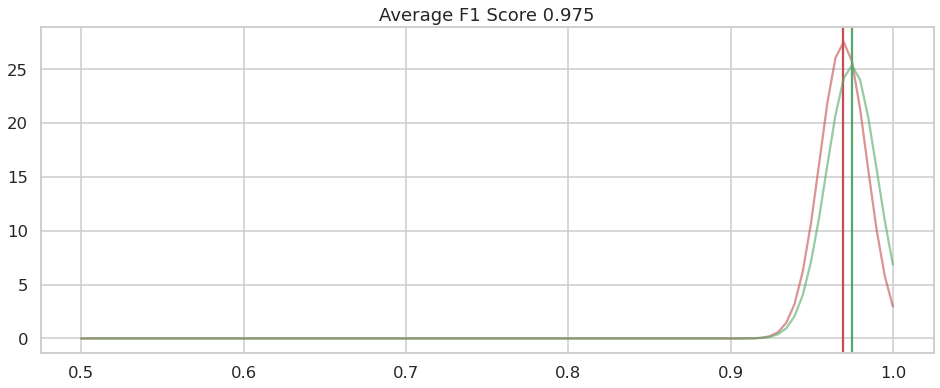

In [19]:
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16,6))

mu, sigma = norm.fit(scores)
x = np.linspace(0.5, 1.0, 100)

ax.plot(x, norm.pdf(x, cv_mu_1, cv_sigma_1), 'r-', alpha=0.6)
ax.axvline(cv_mu_1, color="r")

ax.plot(x, norm.pdf(x, cv_mu_2, cv_sigma_2), 'g-', alpha=0.6)
ax.axvline(cv_mu_2, color="g")

ax.set_title(f"Average F1 Score {mu:.3f}")

exit

So what have we just done?
 - shown how the performance of a model with a single set of hyperparameters affects our score
 - shown that kfold cv can give us a picture of that distribution which is easier to compute that out-of-bootstrap scores and has less leakage
 - so which model to choose? == in this case which data split, which is not what we want, we want to chose a robust estimator so we want to find a model with the best score distribution for a given set of hyperparameters